## Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Read Data

In [2]:
df = pd.read_csv('datasets/abco.us.csv', usecols=['Date','Close'])
df.info, df.head()

(<bound method DataFrame.info of             Date   Close
 0     2005-02-25  19.700
 1     2005-02-28  20.015
 2     2005-03-01  19.905
 3     2005-03-02  19.560
 4     2005-03-03  19.595
 ...          ...     ...
 3196  2017-11-06  53.150
 3197  2017-11-07  53.400
 3198  2017-11-08  53.450
 3199  2017-11-09  52.850
 3200  2017-11-10  53.400
 
 [3201 rows x 2 columns]>,
          Date   Close
 0  2005-02-25  19.700
 1  2005-02-28  20.015
 2  2005-03-01  19.905
 3  2005-03-02  19.560
 4  2005-03-03  19.595)

### Visualize!

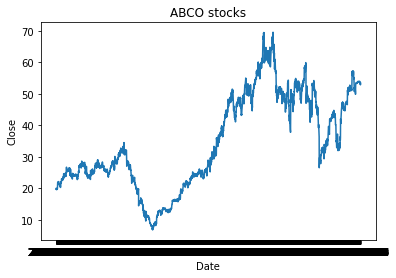

In [4]:
plt.plot(df['Date'],df['Close'])
plt.xlabel('Date')
plt.ylabel('Close (USD)')
plt.title('ABCO stocks')
plt.show()

## Scale the data

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [7]:
scaler = MinMaxScaler(feature_range=(-1, 1))
# Fit to data, then transform it
# Reshape because of single feature array
df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

In [8]:
df['Close']

0      -0.587706
1      -0.577673
2      -0.581177
3      -0.592165
4      -0.591050
          ...   
3196    0.477665
3197    0.485628
3198    0.487220
3199    0.468111
3200    0.485628
Name: Close, Length: 3201, dtype: float64

### The plot should look the same, even with scaled data

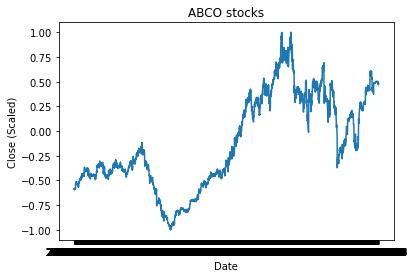

In [9]:
plt.plot(df['Date'],df['Close'])
plt.xlabel('Date')
plt.ylabel('Close (Scaled)')
plt.title('ABCO stocks')
plt.show()

## Split data

In [28]:
def load_data(stock, lookback):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # Create all possible sequences of length lookback
    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])
        
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - test_set_size
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [30]:
lookback = 60 # define sequence length

x_train, y_train, x_test, y_test = load_data(df[['Close']], lookback)

print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (2513, 59, 1)
y_train.shape =  (2513, 1)
x_test.shape =  (628, 59, 1)
y_test.shape =  (628, 1)


### Make training and test sets in torch as tensors

In [31]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [32]:
y_train.size(),x_train.size()

(torch.Size([2513, 1]), torch.Size([2513, 59, 1]))

## Build model

In [34]:
import torch.nn as nn

In [35]:
# Define model parameters
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        self.num_layers = num_layers
        
        # batch_first = True causes input/output tensors to be of shape
        #    (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    # Forward propagation
    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        
        # Detach for truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        
        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states
        out = self.fc(out[:, -1, :])
        # out.size() --> 100, 100
        return out

### Apply model, loss function and optimiser

In [36]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


## Train model

In [37]:
num_epochs = 100
hist = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim = lookback-1

for t in range(num_epochs):
    # Initialize hidden state here if you want your LSTM to be stateless
    
    # Forward pass
    y_train_pred = model(x_train)
    
    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t != 0:
        print("Epoch ", t, "MSE: ", loss.item())
        
    hist[t] = loss.item()
    
    # Zero out gradient, else they well accumulate between epochs
    optimiser.zero_grad()
    
    # Backward propagation
    loss.backward()
    
    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.016997676342725754
Epoch  20 MSE:  0.02036721631884575
Epoch  30 MSE:  0.005682205781340599
Epoch  40 MSE:  0.003763086860999465
Epoch  50 MSE:  0.002130066277459264
Epoch  60 MSE:  0.001700636581517756
Epoch  70 MSE:  0.0013757559936493635
Epoch  80 MSE:  0.0011782296933233738
Epoch  90 MSE:  0.0011325974483042955


### Visualize training

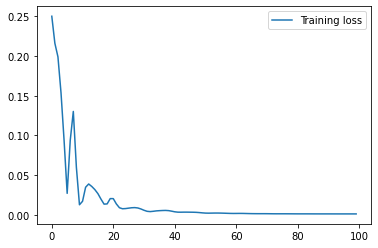

In [38]:
plt.plot(hist, label='Training loss')
plt.legend()
plt.show()

In [40]:
# Confirm number of elements predicted
np.shape(y_train_pred)

torch.Size([2513, 1])

## Make Predictions

In [42]:
import math
from math import sqrt
from sklearn.metrics import mean_squared_error

In [43]:
y_test_pred = model(x_test)

# Good resource to describe reasoning for tensor.detach().numpy(): https://stackoverflow.com/questions/63582590/why-do-we-call-detach-before-calling-numpy-on-a-pytorch-tensor
# Invert predictions to actual numbers from scaled numbers
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# Calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.04 RMSE
Test Score: 1.62 RMSE


## Visualize results

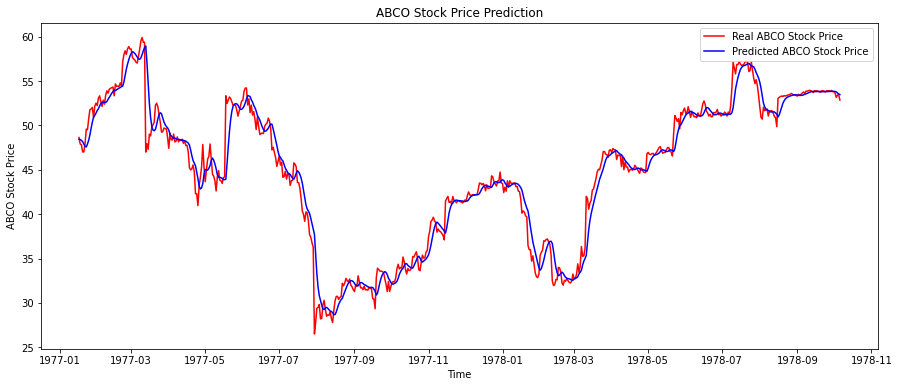

In [44]:
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(df['Close'][len(df['Close'])-len(y_test):].index, y_test, color = 'red', label = 'Real ABCO Stock Price')
axes.plot(df['Close'][len(df['Close'])-len(y_test):].index, y_test_pred, color = 'blue', label = 'Predicted ABCO Stock Price')
#axes.xticks(np.arange(0,394,50))
plt.title('ABCO Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ABCO Stock Price')
plt.legend()
plt.savefig('abco_pred.png')
plt.show()